# charts.ipynb

This notebook generates figures that track the fluctuation in various HbA1c measures during the COVID-19 pandemic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from glob import glob

pd.options.mode.chained_assignment = None

## Data Import and Cleaning

In [2]:
# Read in and append input files
li = []

for file in glob('../output/data/input*.csv'):
    if file.split('_')[1] not in ['ethnicity.csv']:
        df_temp = pd.read_csv(file)
        # Creates date variable based on file name
        df_temp['date'] = file[21:-4]
        # Generates a count column
        df_temp['hba1c_test'] = 1
        li.append(df_temp)
    
df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [3]:
# Segment the data by diabetes status
df_t1dm = df_input.loc[df_input.diabetes_type == 'T1DM'].reset_index(drop=True)
df_t2dm = df_input.loc[df_input.diabetes_type == 'T2DM'].reset_index(drop=True)

In [4]:
# NICE thresholds
threshold_vars = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']

# Numeric vars
num_vars = ['hba1c_test'] + threshold_vars

# Variables by which to subset
subset_vars = ['date'] + num_vars

In [5]:
# Functions to prepare data for visualisation
def sum_by_group(df_in, group=''):
    # Sort by date 
    df_in = df_in.sort_values(['date'])
    if group == '':
        df_out = df_in[subset_vars].groupby(['date']).sum().reset_index()
    else: 
        df_out = df_in[[group] + subset_vars].groupby(['date', group]).sum().reset_index()
    # Redact small numbers
    for var in num_vars: 
        df_out[var] = df_out[var].apply(lambda x: np.where(x < 5, np.nan, x))
    # Reformat dates
    df_out['date'] = df_out['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d').strftime('%b-%y'))
    return df_out

def create_pct(df_in, var):
    df_in[var + '_pct'] = (df_in[var]/df_in['hba1c_test'])*100

def create_subdf(group):
    sum_input = sum_by_group(df_input, group)
    sum_t1dm = sum_by_group(df_t1dm, group)
    sum_t2dm = sum_by_group(df_t2dm, group)

    # Create percentage columns for each threshold measure
    for var in threshold_vars:
        create_pct(sum_input, var)
        create_pct(sum_t1dm, var)
        create_pct(sum_t2dm, var)
            
    return sum_input, sum_t1dm, sum_t2dm

In [6]:
# Monthly total
df_total = sum_by_group(df_input)
df_total_t1dm = sum_by_group(df_t1dm)
df_total_t2dm = sum_by_group(df_t2dm)

for var in threshold_vars:
    create_pct(df_total, var)
    create_pct(df_total_t1dm, var)
    create_pct(df_total_t2dm, var)

In [7]:
# Demographics
df_age, df_age_t1dm, df_age_t2dm = create_subdf('age_group')
df_sex, df_sex_t1dm, df_sex_t2dm = create_subdf('sex')
df_eth, df_eth_t1dm, df_eth_t2dm = create_subdf('ethnicity')
df_reg, df_reg_t1dm, df_reg_t2dm = create_subdf('region')
df_imd, df_imd_t1dm, df_imd_t2dm = create_subdf('imd')
df_ld, df_ld_t1dm, df_ld_t2dm = create_subdf('learning_disability')
df_mi, df_mi_t1dm, df_mi_t2dm = create_subdf('mental_illness')

In [8]:
# Functions to generate charts
def create_chart(title, df, ax):
    sns.lineplot(x='date', y='hba1c_test', data=df, 
                 ax=ax, label="All Tests")
    
    # Set title and make axes labels empty
    ax.fill_between(df.date, df.hba1c_gt_48.min(), 
                    df.hba1c_gt_48, facecolor='blue', alpha=0.2, label='HbA1c > 48')
    ax.fill_between(df.date, df.hba1c_gt_58.min(), 
                    df.hba1c_gt_58, facecolor='blue', alpha=0.4, label='HbA1c > 58')
    ax.fill_between(df.date, df.hba1c_gt_64.min(), 
                    df.hba1c_gt_64, facecolor='blue', alpha=0.7, label='HbA1c > 64')
    ax.fill_between(df.date, df.hba1c_gt_75.min(),
                    df.hba1c_gt_75, facecolor='blue', alpha=1, label='HbA1c > 75')
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    
    ax.set_title(title)
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    
def create_subplot(measure, group, title, df, ax):
    # Create the scatter plot
    sns.lineplot(x='date', y=measure,
                 hue=group, data=df, ax=ax)
    
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests')
    
def create_plotgrid(measure, dfs, ylabel, filename, title):
    fig2, axes2 = plt.subplots(4, 2, figsize=(16, 16), sharex=True, sharey=True)
    fig2.delaxes(ax=axes2[3,1])

    create_subplot(measure, 'age_group', 'Age Group', 
                   dfs[0].loc[dfs[0].age_group != 'missing'], axes2[0,0])
    create_subplot(measure, 'sex', 'Sex', 
                   dfs[1].loc[dfs[1].sex.isin(['F','M'])], axes2[0,1])
    create_subplot(measure, 'ethnicity', 'Ethnicity', 
                   dfs[2], axes2[1,0])
    create_subplot(measure, 'region', 'Region', 
                   dfs[3], axes2[1,1])
    create_subplot(measure, 'imd', 'IMD', 
                   dfs[4], axes2[2,0])
    create_subplot(measure, 'learning_disability', 'Learning Disability', 
                   dfs[5], axes2[2,1])
    create_subplot(measure, 'mental_illness', 'Mental Illness', 
                   dfs[6], axes2[3,0])

    # Set axes labels
    plt.setp(axes2[-1, :],
             xlabel='Date')
    plt.setp(axes2[:, 0],
             ylabel=ylabel)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.suptitle(title, fontsize=16)
    plt.savefig('../output/' + filename + '.png')
    plt.show()

In [9]:
# Lists of dataframes by demographic groups
li_df = [df_age, df_sex, df_eth, df_reg, df_imd, df_ld, df_mi]
li_df_t1dm = [df_age, df_sex, df_eth, df_reg, df_imd, df_ld, df_mi]
li_df_t2dm = [df_age, df_sex, df_eth, df_reg, df_imd, df_ld, df_mi]

_______

## Total Number

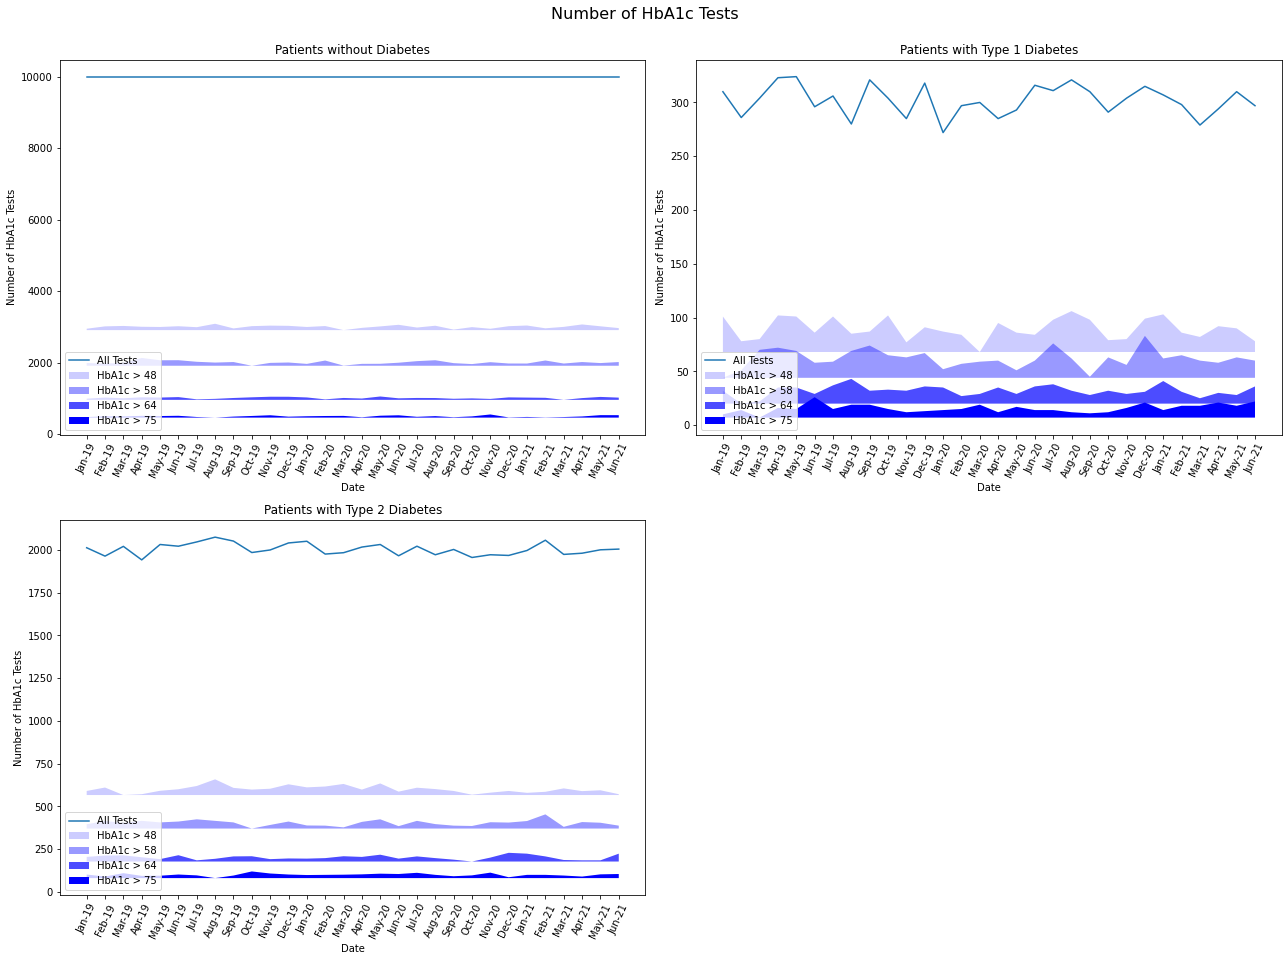

In [10]:
# Total number
fig, axes = plt.subplots(2,2, figsize=(18, 14))
fig.delaxes(ax=axes[1,1])
create_chart('Patients without Diabetes', df_total, axes[0,0])
create_chart('Patients with Type 1 Diabetes', df_total_t1dm, axes[0,1])
create_chart('Patients with Type 2 Diabetes', df_total_t2dm, axes[1,0])

fig.suptitle('Number of HbA1c Tests', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../output/total_by_dm.png')
plt.show()

### By Demographics

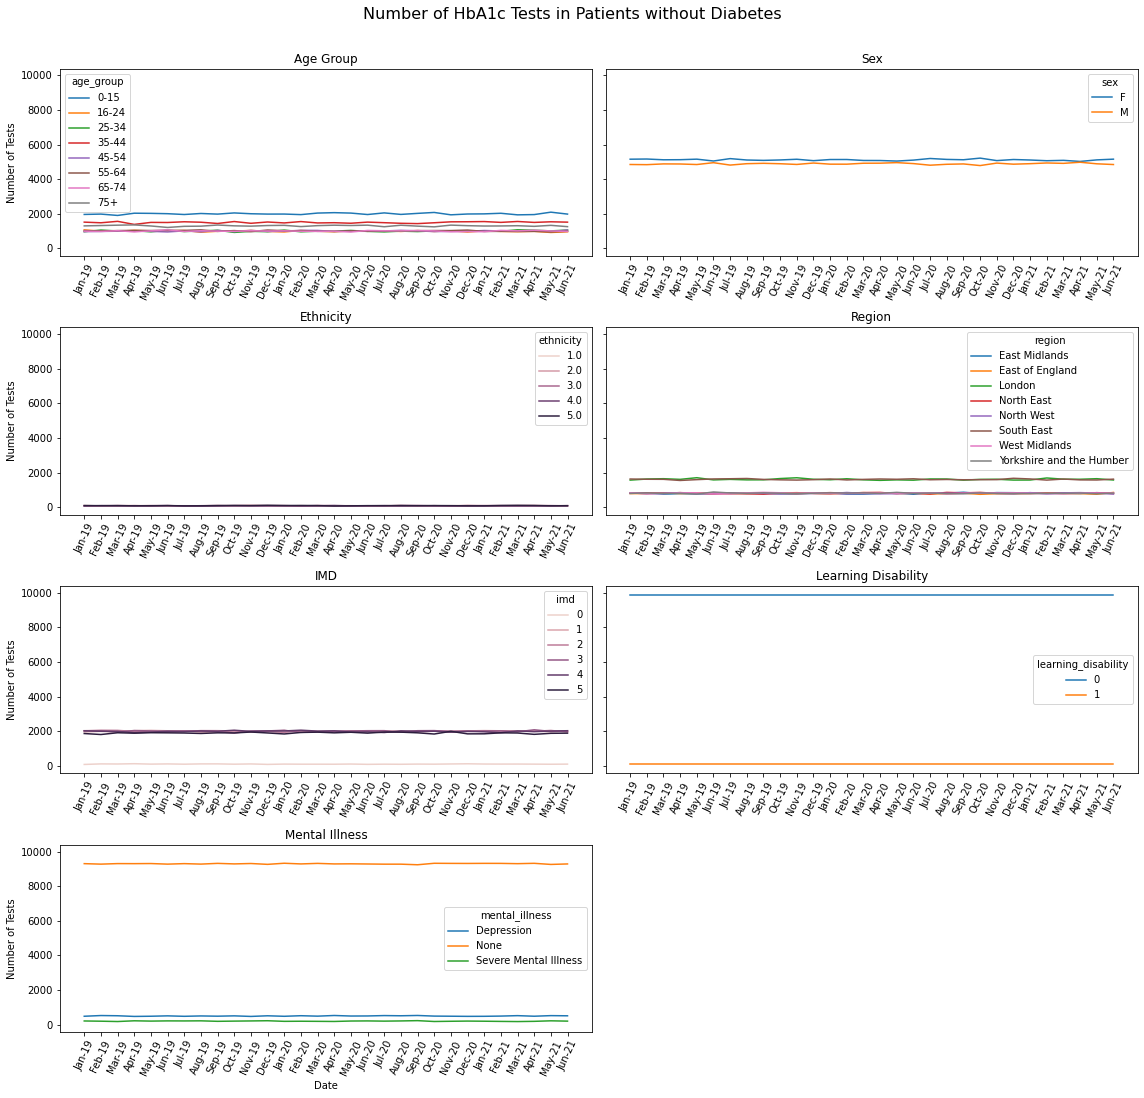

In [11]:
# Patients without diabetes
create_plotgrid('hba1c_test', li_df, 'Number of Tests',
                'total_nodm_by_group', 'Number of HbA1c Tests in Patients without Diabetes')

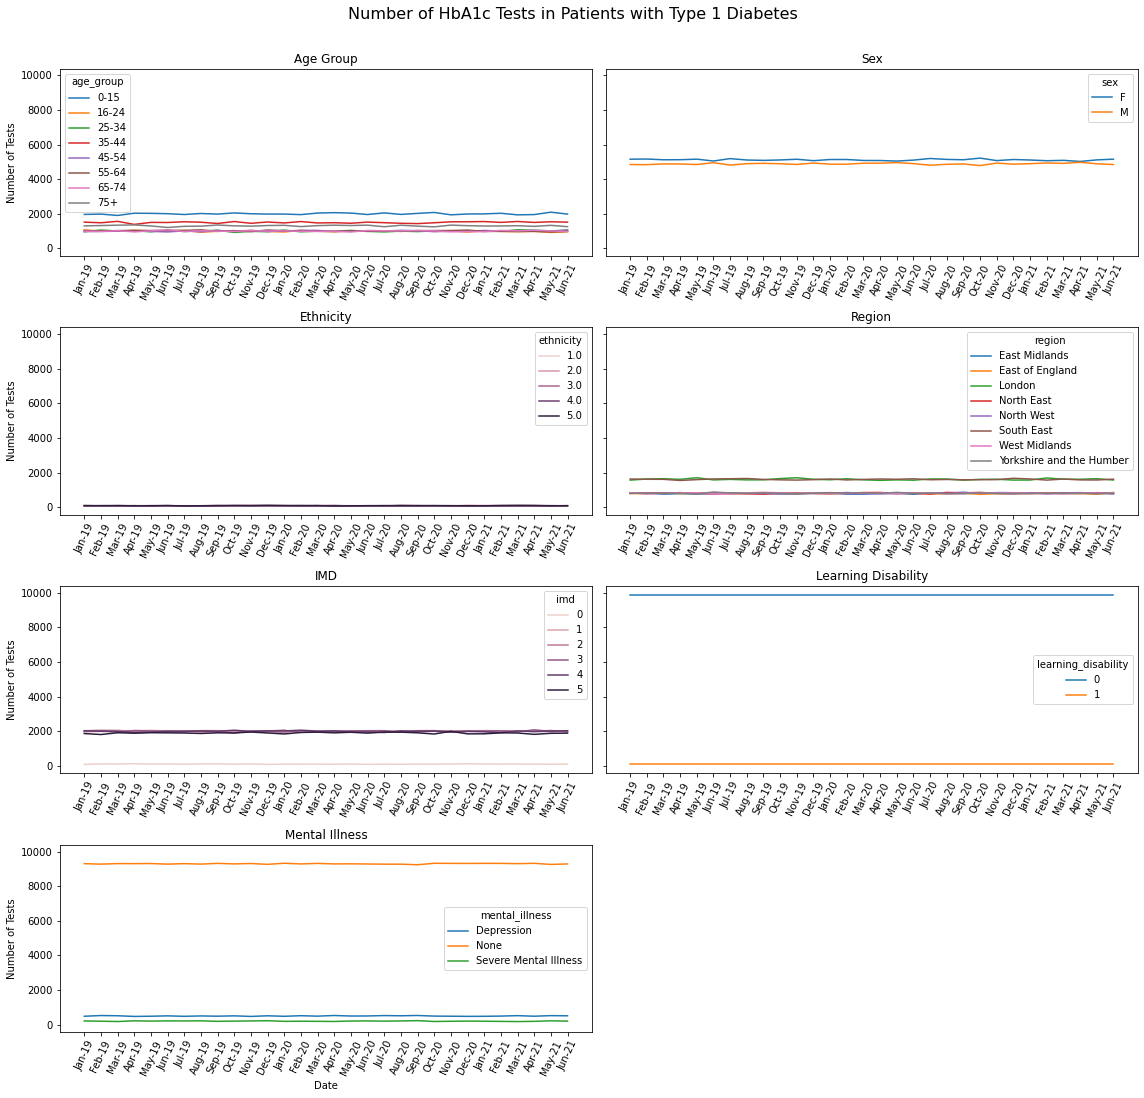

In [12]:
# Patients with T1DM
create_plotgrid('hba1c_test',li_df_t1dm, 'Number of Tests',
                'total_t1dm_by_group', 'Number of HbA1c Tests in Patients with Type 1 Diabetes')

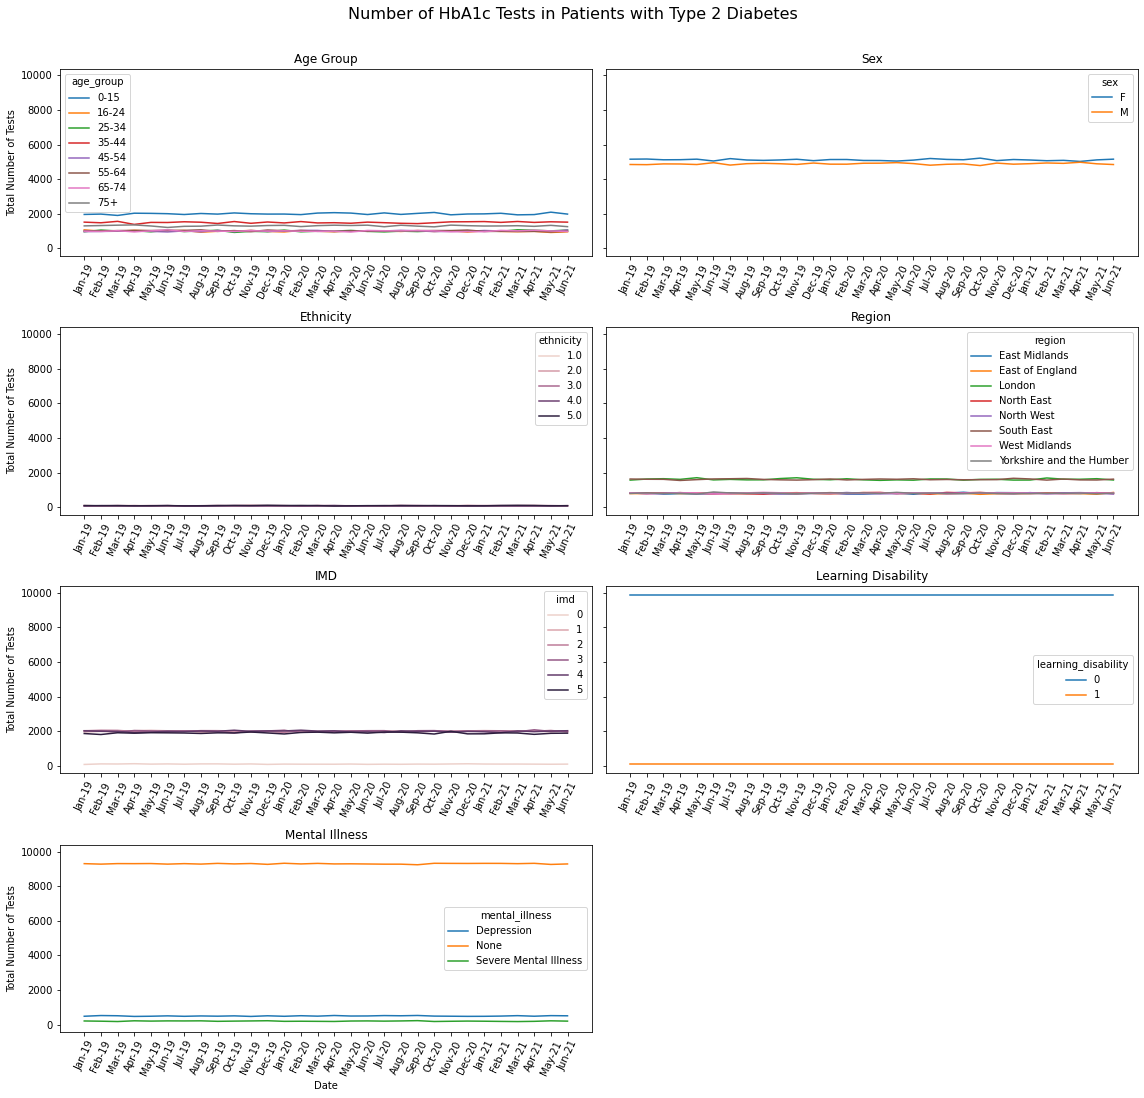

In [13]:
# Patients with T2DM
create_plotgrid('hba1c_test', li_df_t2dm, 'Total Number of Tests',
                'total_t2dm_by_group', 'Number of HbA1c Tests in Patients with Type 2 Diabetes')

_________

## Tests by Threshold for Those with T2DM

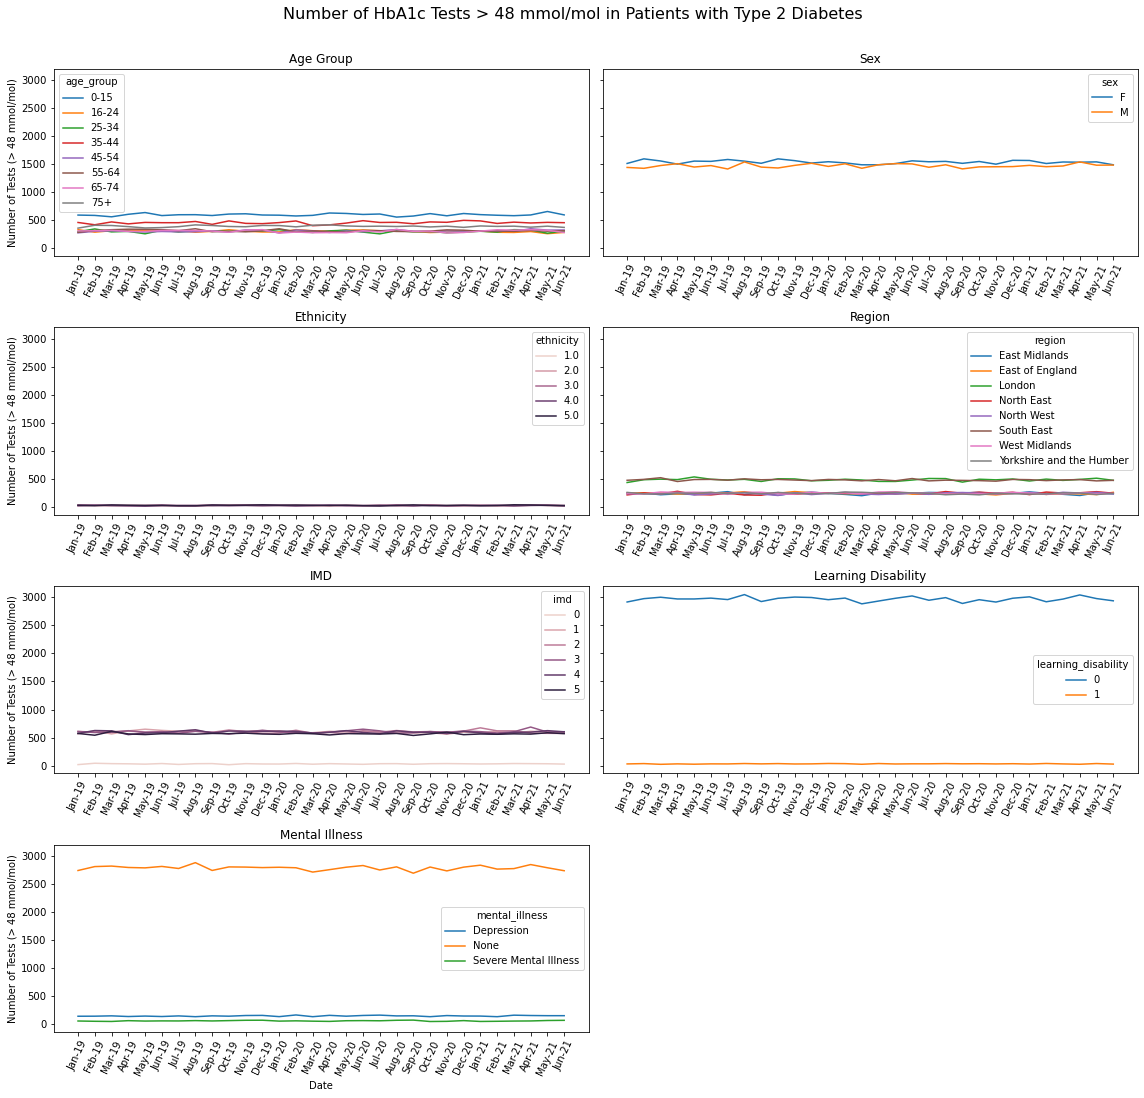

In [14]:
# > 48
create_plotgrid('hba1c_gt_48',li_df_t2dm, 'Number of Tests (> 48 mmol/mol)',
                'gt48_t2dm_by_group', 'Number of HbA1c Tests > 48 mmol/mol in Patients with Type 2 Diabetes')

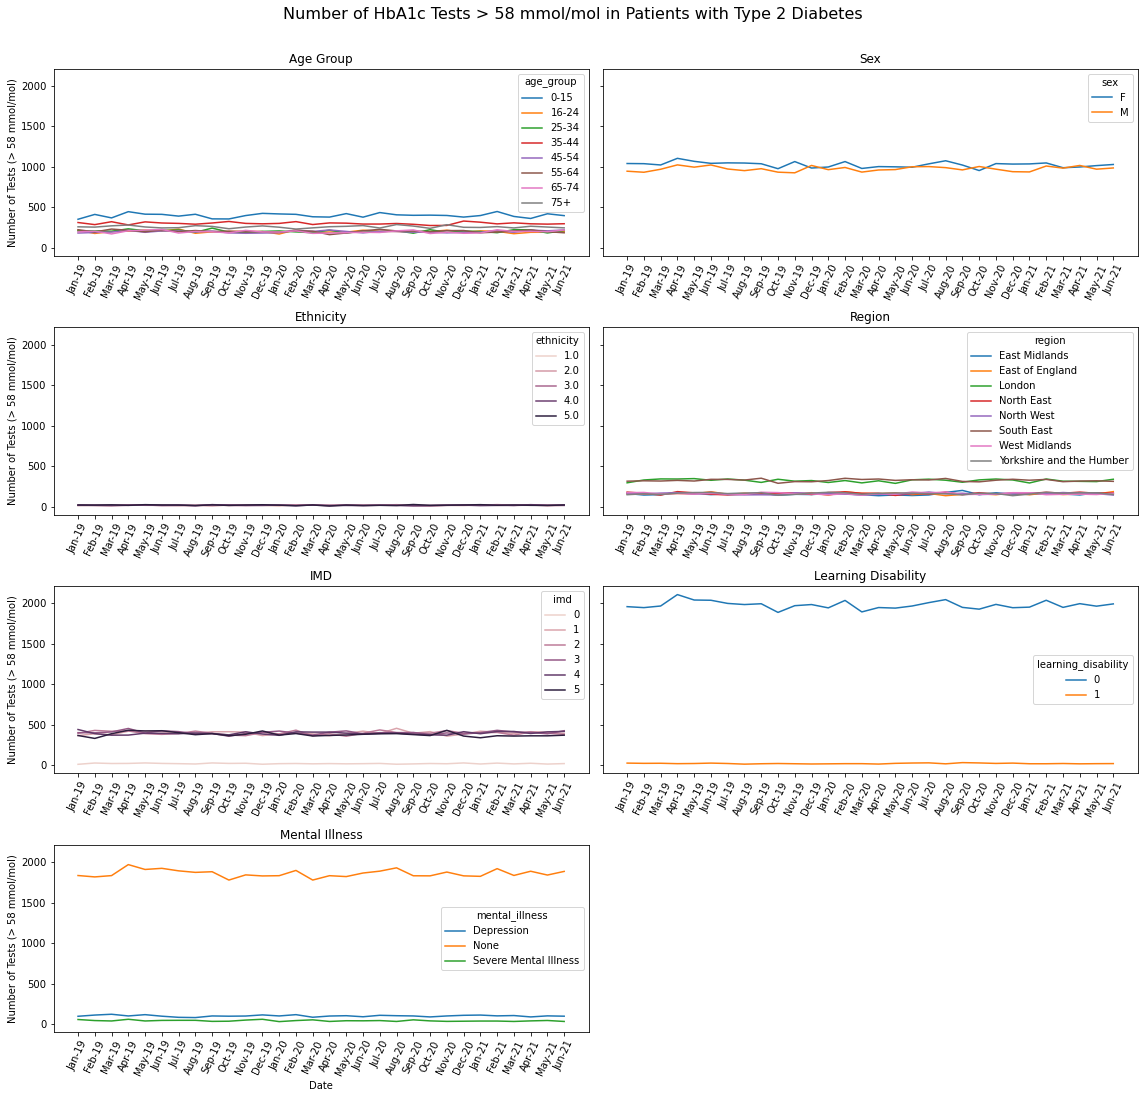

In [15]:
# > 58
create_plotgrid('hba1c_gt_58',li_df_t2dm, 'Number of Tests (> 58 mmol/mol)',
                'gt58_t2dm_by_group', 'Number of HbA1c Tests > 58 mmol/mol in Patients with Type 2 Diabetes')

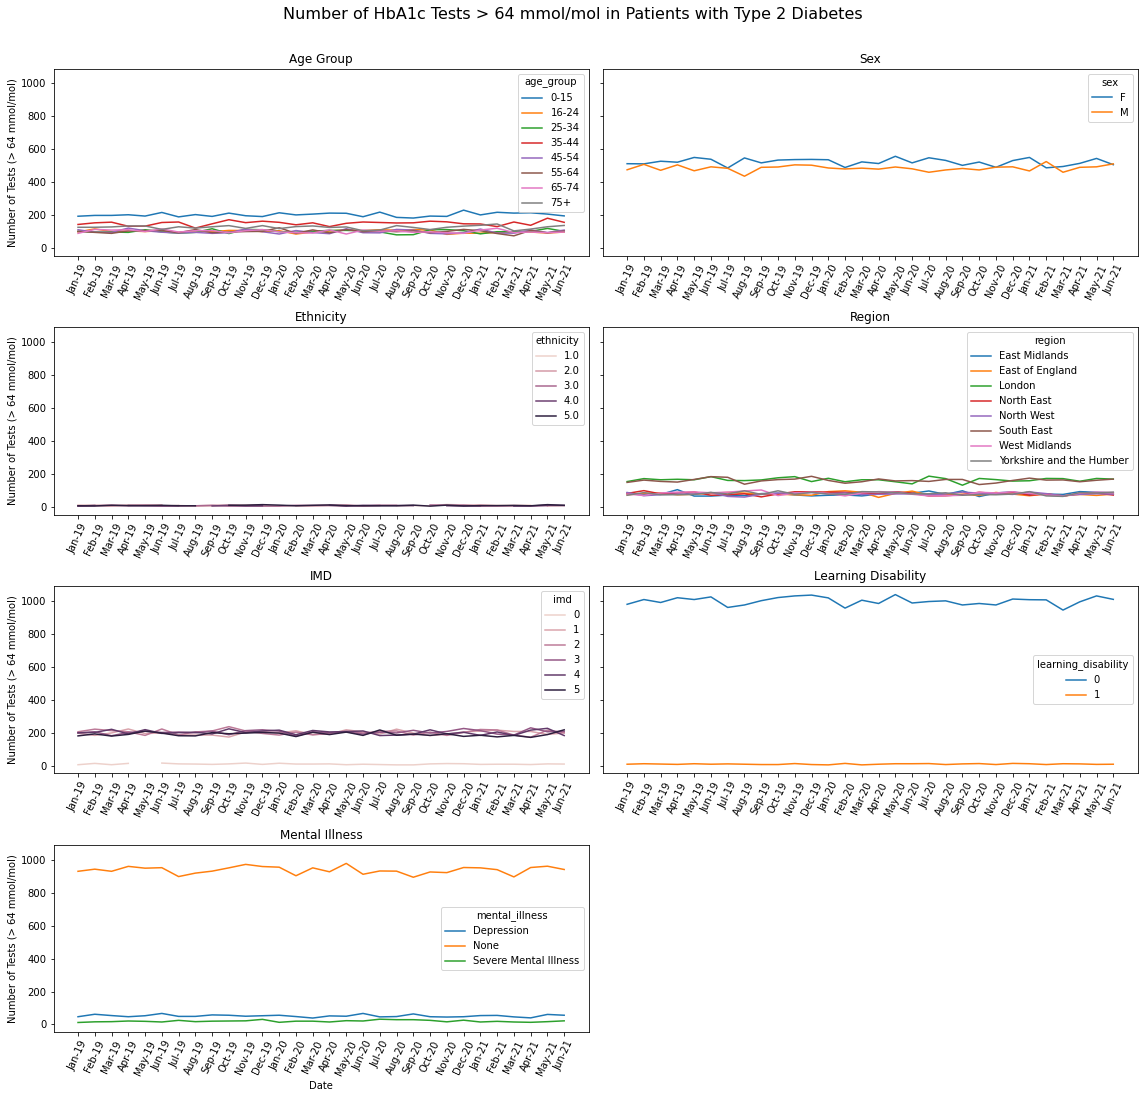

In [16]:
# > 64
create_plotgrid('hba1c_gt_64',li_df_t2dm, 'Number of Tests (> 64 mmol/mol)',
                'gt64_t2dm_by_group','Number of HbA1c Tests > 64 mmol/mol in Patients with Type 2 Diabetes')

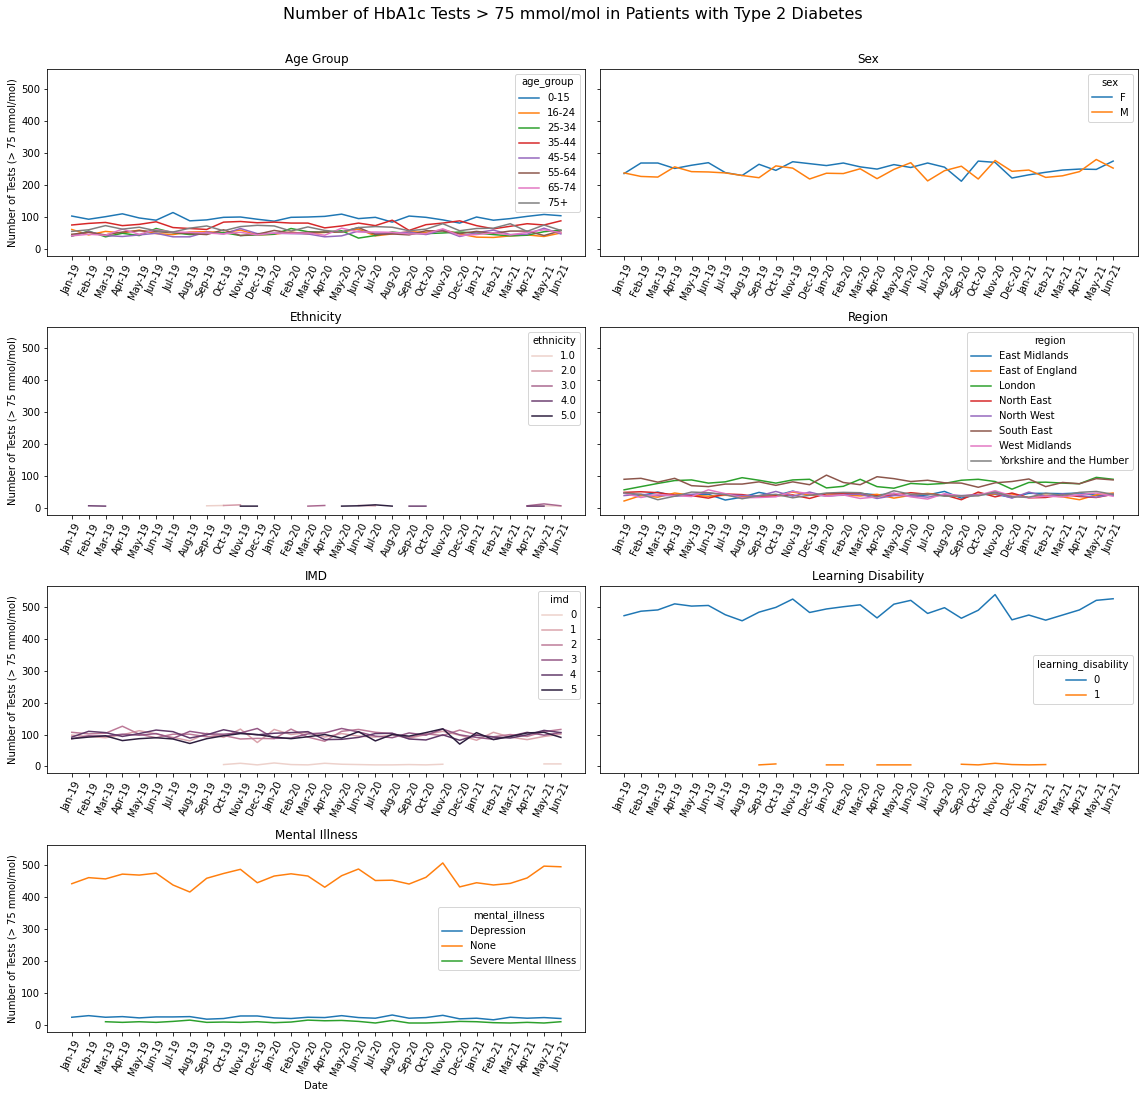

In [17]:
# > 75
create_plotgrid('hba1c_gt_75',li_df_t2dm, 'Number of Tests (> 75 mmol/mol)',
                'gt75_t2dm_by_group','Number of HbA1c Tests > 75 mmol/mol in Patients with Type 2 Diabetes')

___

## Percent of Tests by Target Threshold

In [18]:
# Subset to percentage variables
df_t2dm_pct = df_total_t2dm[['date','hba1c_gt_48_pct','hba1c_gt_58_pct',
                            'hba1c_gt_64_pct', 'hba1c_gt_75_pct']]

In [19]:
# Wide to long
df_t2dm_pct_wide = pd.melt(df_t2dm_pct, id_vars=['date'], value_vars=['hba1c_gt_48_pct','hba1c_gt_58_pct',
                                                                      'hba1c_gt_64_pct', 'hba1c_gt_75_pct']).reset_index(drop=True)

In [20]:
# Format variable
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_48_pct', 'variable'] = '> 48 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_58_pct', 'variable'] = '> 58 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_64_pct', 'variable'] = '> 64 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_75_pct', 'variable'] = '> 75 mmol/mol'
df_t2dm_pct_wide = df_t2dm_pct_wide.rename(columns={'variable':'threshold'})

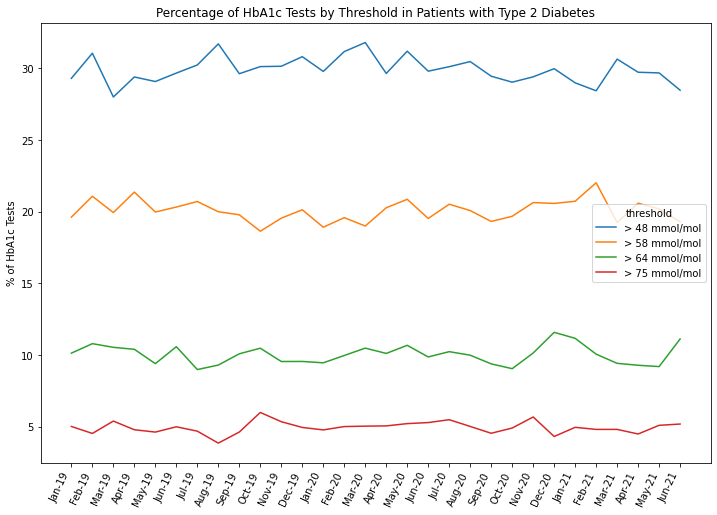

In [21]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='threshold', data=df_t2dm_pct_wide)
    
# Set title and make axes labels empty
ax.set_title('Percentage of HbA1c Tests by Threshold in Patients with Type 2 Diabetes')
ax.set_xlabel('')
ax.set_ylabel('% of HbA1c Tests')
fig.autofmt_xdate(rotation=65)

plt.savefig('../output/pct_t2dm.png')
plt.show()

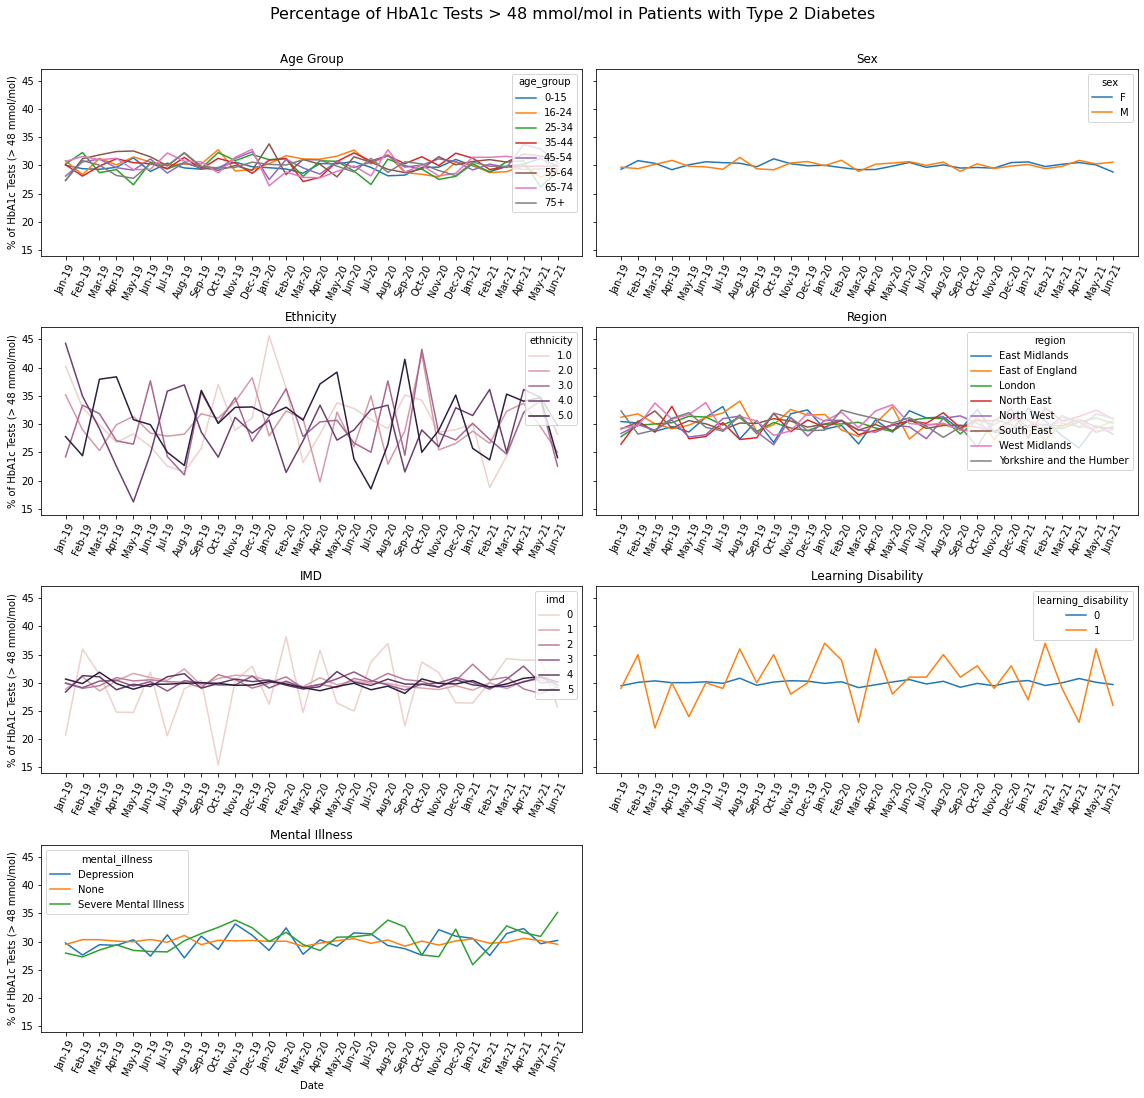

In [22]:
# > 48
create_plotgrid('hba1c_gt_48_pct',li_df_t2dm, '% of HbA1c Tests (> 48 mmol/mol)',
                'pct_t2dm_gt48','Percentage of HbA1c Tests > 48 mmol/mol in Patients with Type 2 Diabetes')

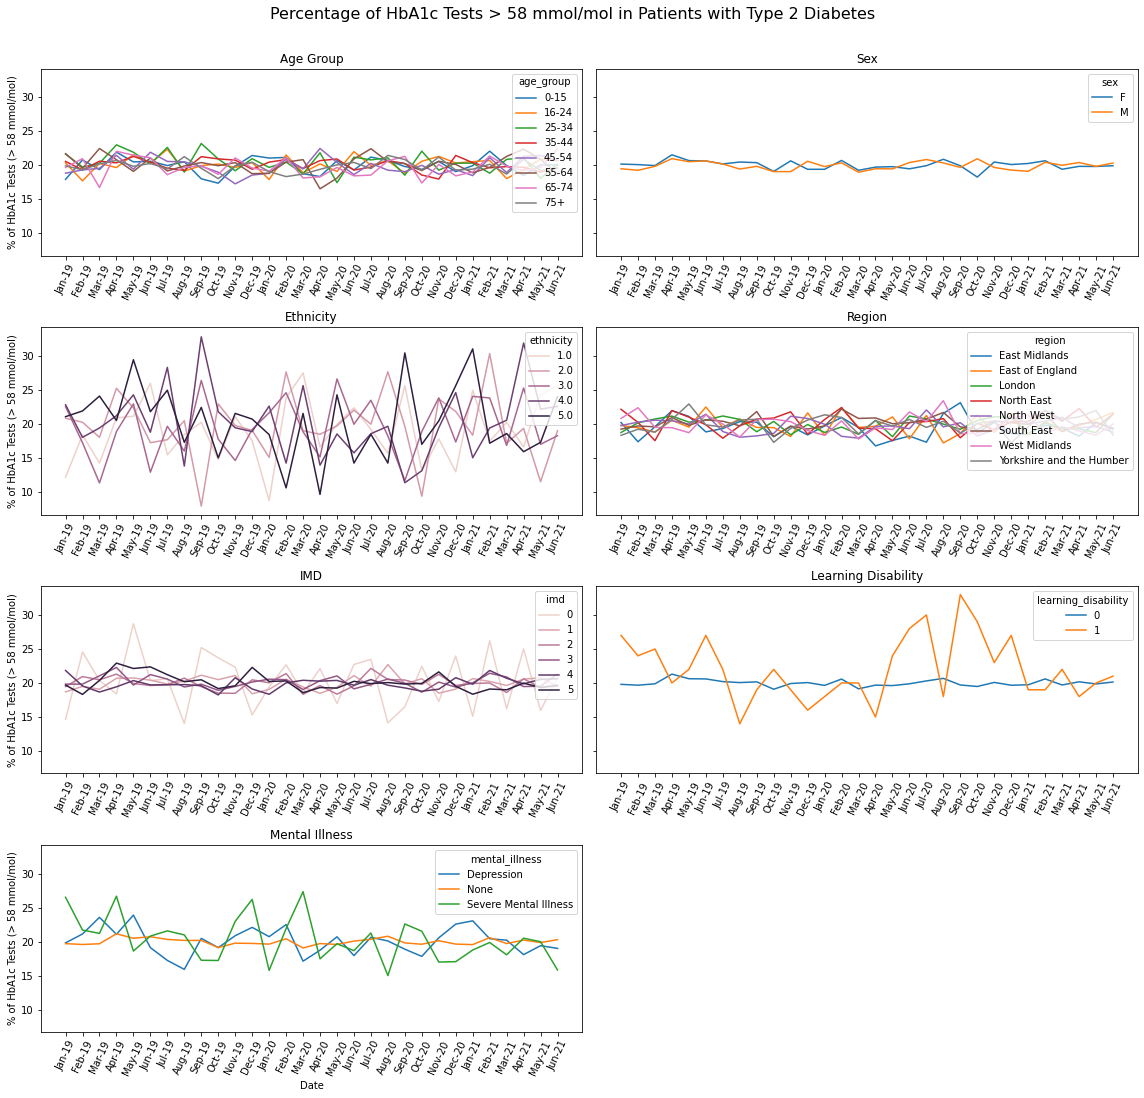

In [23]:
# > 58
create_plotgrid('hba1c_gt_58_pct',li_df_t2dm, '% of HbA1c Tests (> 58 mmol/mol)',
                'pct_t2dm_gt58', 'Percentage of HbA1c Tests > 58 mmol/mol in Patients with Type 2 Diabetes')

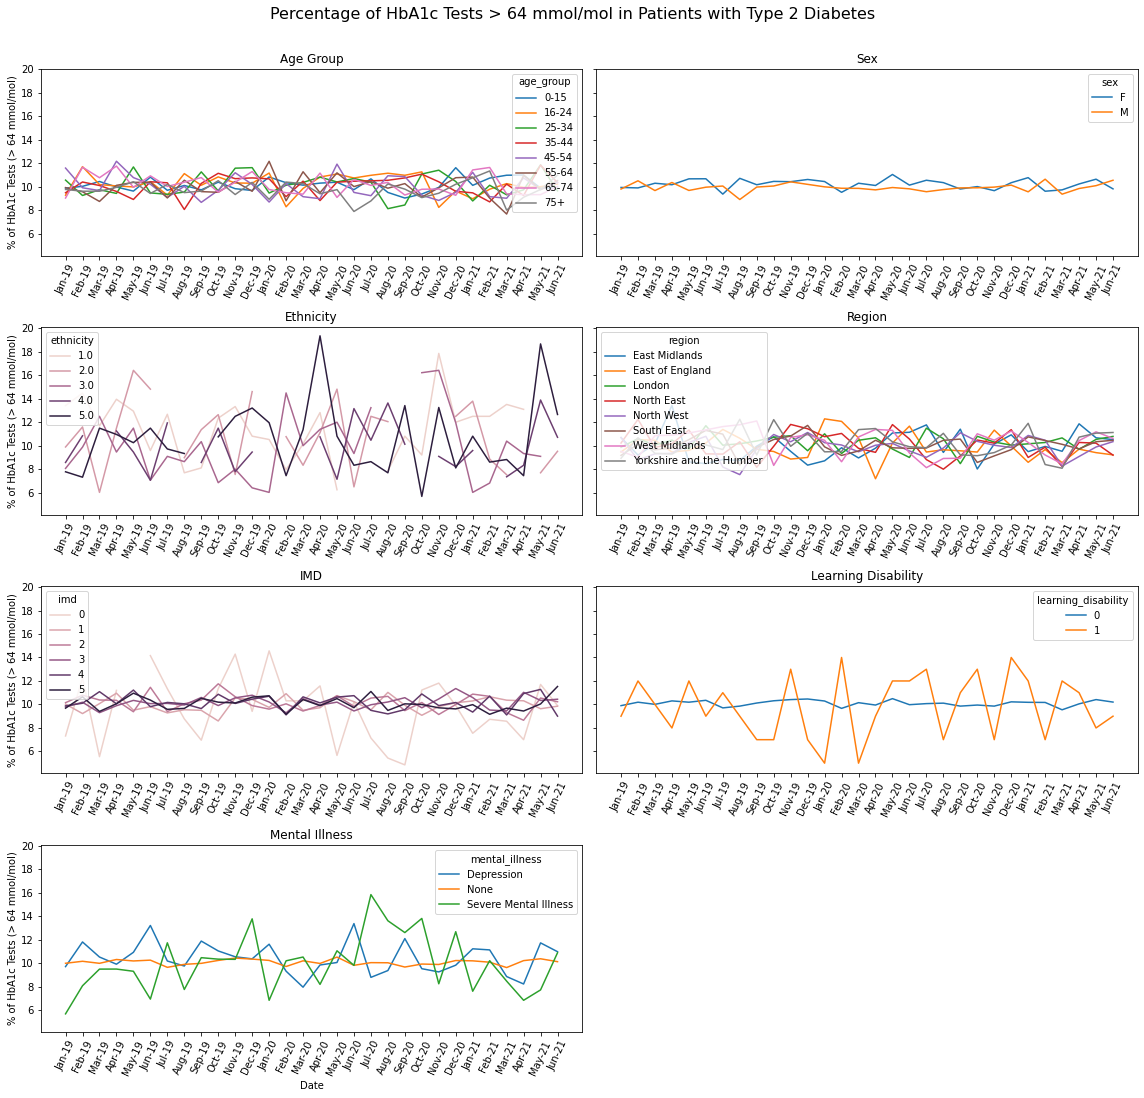

In [24]:
# > 64
create_plotgrid('hba1c_gt_64_pct',li_df_t2dm, '% of HbA1c Tests (> 64 mmol/mol)',
                'pct_t2dm_gt64', 'Percentage of HbA1c Tests > 64 mmol/mol in Patients with Type 2 Diabetes')

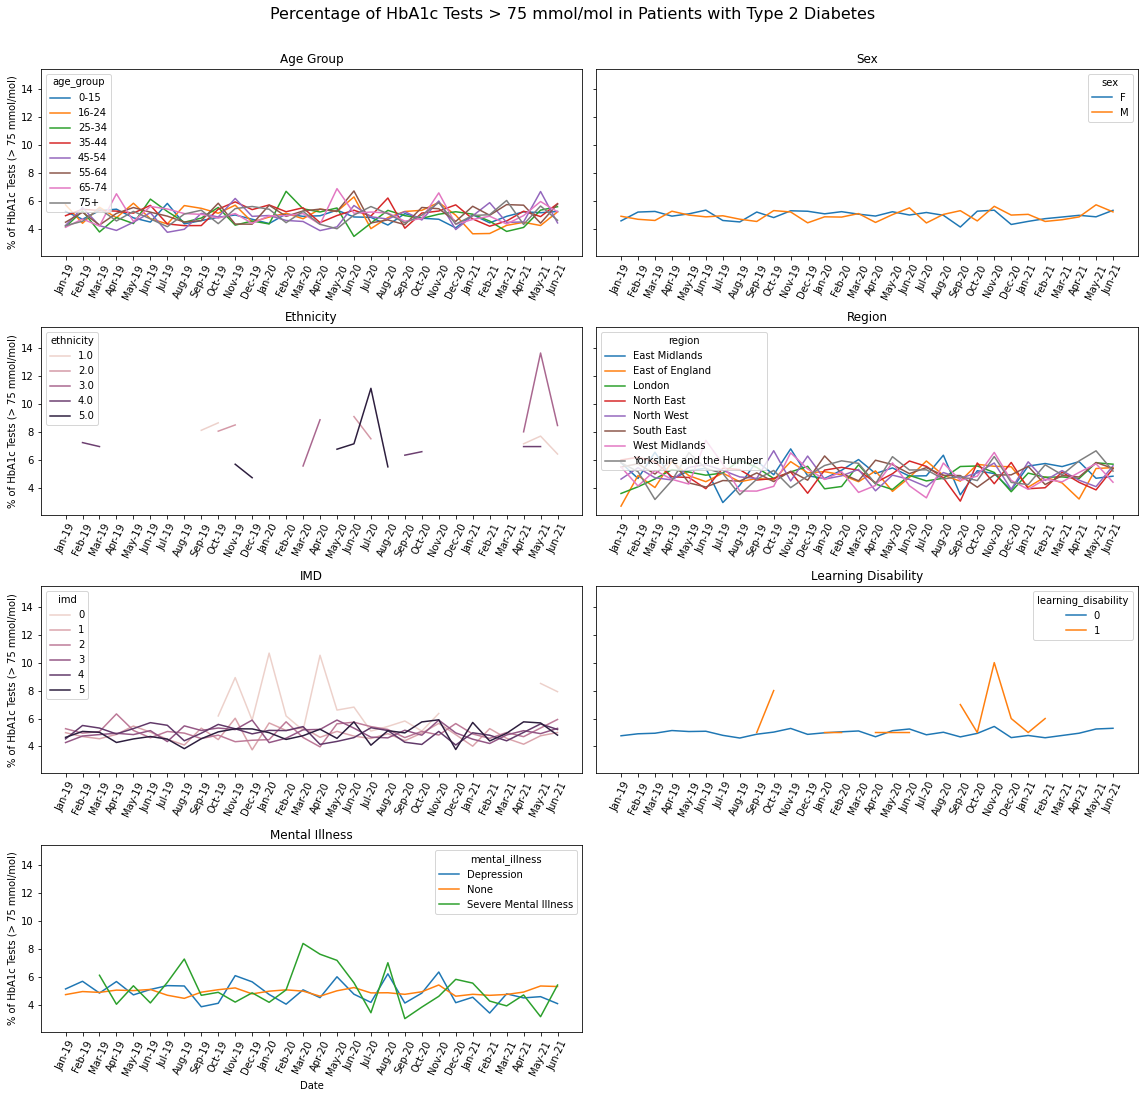

In [25]:
# > 75
create_plotgrid('hba1c_gt_75_pct',li_df_t2dm, '% of HbA1c Tests (> 75 mmol/mol)',
                'pct_t2dm_gt75', 'Percentage of HbA1c Tests > 75 mmol/mol in Patients with Type 2 Diabetes')

______

## Median of Test Values

In [26]:
# Get patient subset with poor glycemic control prior to the pandemic
pat_subset = df_t2dm.loc[df_t2dm.prev_hba1c_mmol_per_mol_date > 58]['patient_id'].unique()
df_t2dm_subset = df_t2dm.loc[df_t2dm.patient_id.isin(pat_subset)]

In [27]:
# 58-74 range 
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 58) & 
                   (df_t2dm_subset.prev_hba1c_mmol_per_mol < 75), 
                   'hba1c_val_58_74'] = df_t2dm_subset.hba1c_mmol_per_mol

# > 75
df_t2dm_subset.loc[(df_t2dm_subset.prev_hba1c_mmol_per_mol > 75),
                   'hba1c_val_75'] = df_t2dm_subset.hba1c_mmol_per_mol

In [28]:
# Get median of test values
def gen_median(df_in, group=''):
    if group == '':
        df_out = df_in[['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date']).median().reset_index()
    else:
        df_out = df_in[[group] + ['date','hba1c_val_58_74','hba1c_val_75']].groupby(['date', group]).median().reset_index()
    # Reformat dates
    df_out['date'] = df_out['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d').strftime('%b-%y'))
    return df_out

In [29]:
df_med_t2dm = gen_median(df_t2dm_subset)
df_med_t2dm_age = gen_median(df_t2dm_subset, 'age_group')
df_med_t2dm_sex = gen_median(df_t2dm_subset, 'sex')
df_med_t2dm_eth = gen_median(df_t2dm_subset, 'ethnicity')
df_med_t2dm_reg = gen_median(df_t2dm_subset, 'region')
df_med_t2dm_imd = gen_median(df_t2dm_subset, 'imd')
df_med_t2dm_ld = gen_median(df_t2dm_subset, 'learning_disability')
df_med_t2dm_mi = gen_median(df_t2dm_subset, 'mental_illness')

In [30]:
df_med_t2dm_wide = pd.melt(df_med_t2dm, id_vars=['date'], value_vars=['hba1c_val_58_74', 'hba1c_val_75'])

In [31]:
# Format variable and date 
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_58_74', 'variable'] = '58-74 mmol/mol'
df_med_t2dm_wide.loc[df_med_t2dm_wide.variable == 'hba1c_val_75', 'variable'] = '> 75 mmol/mol'
df_med_t2dm_wide = df_med_t2dm_wide.rename(columns={'variable':'range_in_prev_15_mo'})

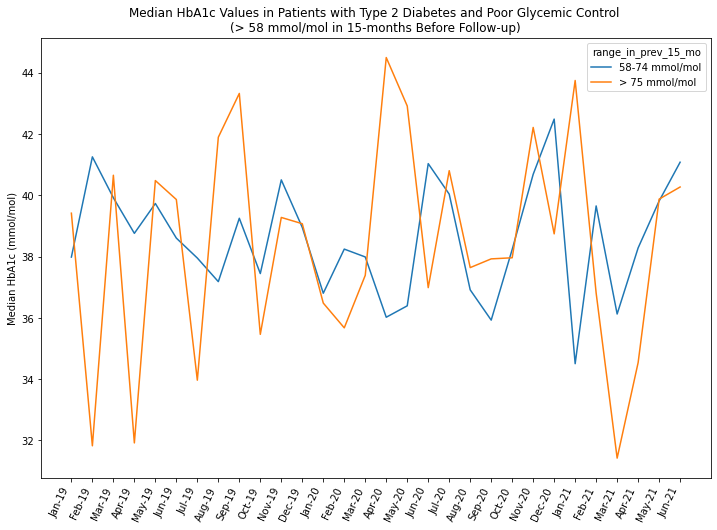

In [37]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='range_in_prev_15_mo', data=df_med_t2dm_wide)
    
# Set title and make axes labels empty
ax.set_title('Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(> 58 mmol/mol in 15-months Before Follow-up)')
ax.set_xlabel('')
ax.set_ylabel('Median HbA1c (mmol/mol)')
fig.autofmt_xdate(rotation=65)

plt.savefig('../output/med_t2dm.png')
plt.show()

In [33]:
# List of median dfs
li_df_med_t2dm = [df_med_t2dm_age, df_med_t2dm_sex, df_med_t2dm_eth,
                  df_med_t2dm_reg, df_med_t2dm_imd, df_med_t2dm_ld, 
                  df_med_t2dm_mi]

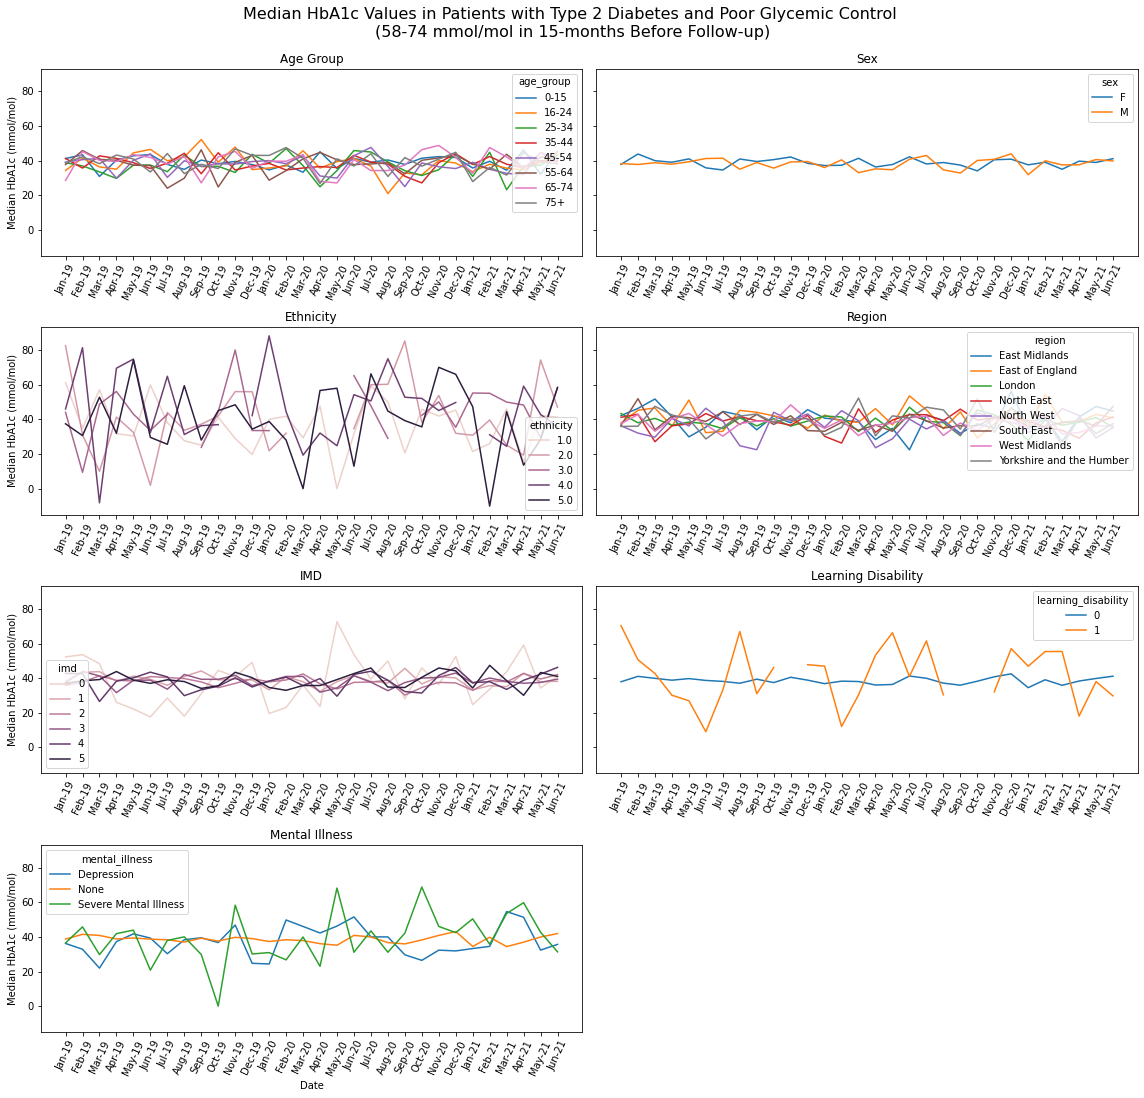

In [38]:
# 58-74 mmol/mol
create_plotgrid('hba1c_val_58_74',li_df_med_t2dm, 'Median HbA1c (mmol/mol)','med_t2dm_58_74',
                'Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(58-74 mmol/mol in 15-months Before Follow-up)')

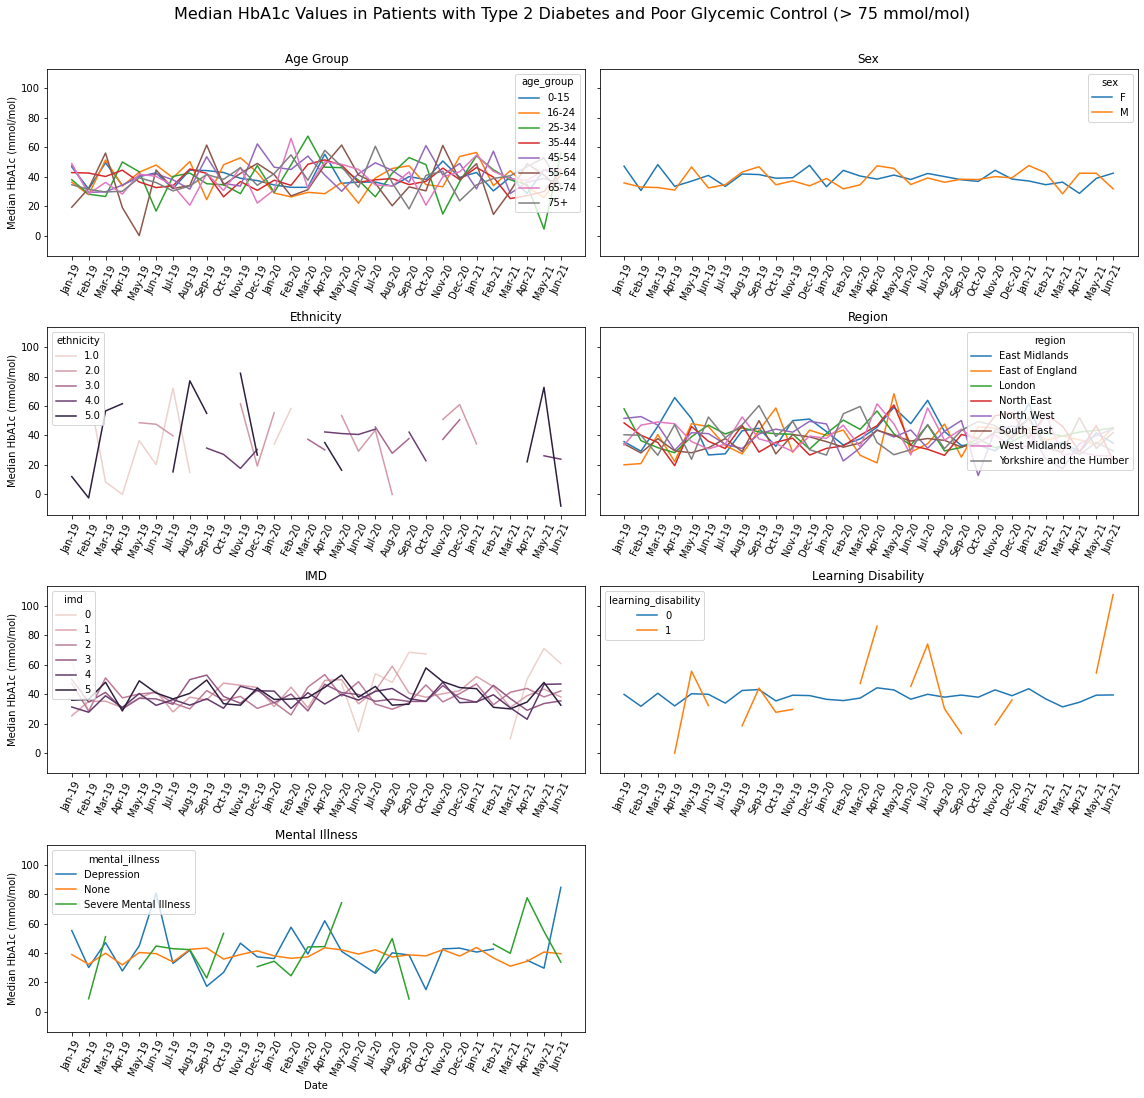

In [35]:
# > 75 mmol/mol
create_plotgrid('hba1c_val_75',li_df_med_t2dm, 'Median HbA1c (mmol/mol)','med_t2dm_gt75',
                'Median HbA1c Values in Patients with Type 2 Diabetes and Poor Glycemic Control \n(> 75 mmol/mol in 15-months Before Follow-up)')